<a href="https://colab.research.google.com/github/ahdhani/Support_Resistance_from_Orderbook/blob/main/depthSupportResistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def depthDataDiff(pair="B-OGN_USDT",rangeOfQty=.5):

  #API Data accesing
  base_url = "https://public.coindcx.com/market_data/orderbook?pair="+pair
  response = requests.get(base_url)
  data = response.json()
  bids = data['bids']
  asks = data['asks']
  asks = dict(sorted(asks.items()))

  qtyCF = 0
  for x in asks:
    qtyCF+=float(asks[x])
    asks[x]=qtyCF

  qtyCF = 0
  for x in bids:
    qtyCF+=float(bids[x])
    bids[x]=qtyCF

  askKey = float(next(iter(asks)))
  # askQty = float(asks[askKey])

  # print(bids)
  # plotResult(x=list(map(float, bids.keys())),y=list(map(float, bids.values())),color = 'green',
  #            x2=list(map(lambda x :2*askKey - float(x), asks.keys())),y2=list(map(float , asks.values())),color2 = 'red')

In [2]:
import requests
import bisect
import matplotlib.pyplot as plt
import copy
import numpy as np



def plotSpreadOperation(x,y,label):
  # plt.subplot(2, 1, 2)
  plt.figure(figsize=(10,7))
  plt.plot(x,y, color='green', label= label)
  plt.grid(True)
  plt.legend(loc='upper left')
  plt.show()

def leftLimitExtract(bids,leftLimit):
  res = []
  for x in bids:
    num1 = float(x)
    if num1<leftLimit:
      break
    num2 = float(bids[x])
    res.append([num1,num2])
  return res

def rightLimitExtract(asks,rightLimit):
  res = []
  for x in asks:
    num1 = float(x)
    if num1 > rightLimit:
      break
    num2 = float(asks[x])
    res.append([num1,num2])
  return res

def limitExtractDepth(bids,asks,limitPercent):
  currPrice = float(next(iter(bids)))
  leftLimit = currPrice - (currPrice*limitPercent)
  rightLimit = currPrice + (currPrice*limitPercent)

  bids = leftLimitExtract(bids,leftLimit)
  asks = rightLimitExtract(asks,rightLimit)
  return bids,asks

def getDepthData(pair):
  base_url = "https://public.coindcx.com/market_data/orderbook?pair="+pair
  response = requests.get(base_url)
  data = response.json()
  bids = data['bids']
  asks = data['asks']
  asks = dict(sorted(asks.items()))
  return bids,asks

def getOHLC(pair):
  base_url = "https://public.coindcx.com/market_data/candles?interval=1m&pair="+pair
  response = requests.get(base_url)
  data = response.json()
  return data

# def parseToBarData(data, barNum=8):
#   res = []
#   for x in range(0,len(data),barNum):
#     # print(data[x][0])
#     mean = sum((first for first, second in data[x:x+barNum])) / len(data[x:x+barNum])
#     res.append([mean,sum((second for first, second in data[x:x+barNum]))])
#   return res

def parseToBarData(data, binNum=50):
  arr = np.array(data)
  x,y = np.histogram(arr[:,0],weights=arr[:,1], bins = binNum)
  y = [(y[i]+y[i-1])/2 for i in range(1,len(y))]
  return np.column_stack((y,x)).tolist()

def getSupportResistance(bids,asks,pair,lineNumber,limitPercent):

  support = parseToBarData(bids)
  resistance = parseToBarData(asks)
  support.sort(key = lambda x: x[1],reverse=True)
  resistance.sort(key = lambda x: x[1],reverse=True)

  return resistance[:lineNumber],support[:lineNumber]


def depthDataPred(bids,asks,pair="B-NANO_USDT",limitPercent = 0.2,rangeOfQty=.1):

  x = []
  y = []
  totalQty = 0

  i=0
  j=0
  while len(bids)>i and len(asks)>j:
    bidKey = bids[i][0]
    askKey = asks[j][0]
    bidQty = bids[i][1]
    askQty = asks[j][1]

    meanPrice =( bidKey + askKey)/2

    if bidQty>askQty:
      qtyLeft = bidQty - askQty
      totalQty += askQty
      x.append(totalQty)
      y.append(meanPrice)
      j+=1
      bids[i][1] = qtyLeft
    elif bidQty<askQty:
      qtyLeft = askQty - bidQty
      totalQty += bidQty
      x.append(totalQty)
      y.append(meanPrice)
      i+=1
      asks[j][1] = qtyLeft
    else:
      totalQty += askQty
      x.append(totalQty)
      y.append(meanPrice)
      i+=1
      j+=1
 
  print(totalQty)
  # print(res)
  plotSpreadOperation(x,y,pair)

def getSwingScorePower(support,resistance,price):

  supMean = 0 
  supQty = 0
  for x in support:
    supMean += x[0]*x[1]
    supQty+= x[1]
  supMean = supMean / supQty

  resMean = 0 
  resQty = 0
  for x in resistance:
    resMean += x[0]*x[1]
    resQty+= x[1]
  resMean = resMean / resQty

  score = ((resMean - price) * supQty) - ((price - supMean) * resQty)
  power = (resMean - price) / (resMean - supMean)
  return score,power

def plotSupportResistance(close,bids,asks,pair,lineNumber=5,limitPercent=.1):


  resistance,support = getSupportResistance(bids,asks,pair,lineNumber,limitPercent)

  maxRes = resistance[0][0]
  maxSup = support[0][0]
  # swingPower =( maxRes - close[-1]) /( maxRes - maxSup)
  swingScore,swingPower = getSwingScorePower(support,resistance,close[-1])

  print("MaxRes : " + str(maxRes))
  print("MaxSup : " + str(maxSup))
  print("SwingPower : " + str(swingPower))
  print("SwingScore : " + str(swingScore))
  maxQty = max(resistance[0][1],support[0][1])

  minPriceRes = min(resistance)[0]
  minPriceSup = max(support)[0]

  # plt.subplot(2, 1, 1)
  plt.figure(figsize=(12,7))
  plt.plot(close, color='blue', label= pair)
  for x in resistance:
    plt.axhline(y = x[0], color = 'r', linestyle = '-',linewidth=(x[1]/maxQty)*4,label=minPriceRes==x[0] and x[0] or None)
  for x in support:
    plt.axhline(y = x[0], color = 'g', linestyle = '-',linewidth=(x[1]/maxQty)*4,label=minPriceSup==x[0] and x[0] or None)
  plt.grid(True)
  plt.legend(loc='upper left')
  plt.show()


def main(pair,lineNumber = 5,limitPercent = 0.05):
  ohlc = getOHLC(pair)
  close = list(map(lambda x:x['close'],ohlc))
  close.reverse()

  bids,asks = getDepthData(pair)
  bids,asks = limitExtractDepth(bids,asks,limitPercent)
  # bids
  if len(bids)==0 or len(asks)==0 or len(close)==0:
    print("data Incomplete ")
    return

  plotSupportResistance(close,bids,asks,pair,lineNumber,limitPercent)
  # depthDataPred(bids,asks,pair,lineNumber,limitPercent)

Pair			SwingPower		ProfitPercent
B-MATIC_USDT		0.6153866273678492		-17214.353264725614		1.0718963941276325
B-ADA_USDT		0.5922208040632023		155017.05893733		1.0631973254311984
B-ONG_USDT		0.7970642379780358		2674.3090519203115		1.0253496948118006
B-OGN_USDT		0.6457892509120721		1584.6913237052167		1.0282460108053775
B-KSM_USDT		0.5321386981143146		1471.91612488404		1.0199281089073573
B-XRP_USDT		0.63897319796316		100691.55039875553		1.0772453062480762
data Incomplete B-NANO_USDT
B-SUPER_USDT		0.7161257069697258		8758.09498495997		1.0514657980456026
B-TKO_USDT		0.43962440027121513		340.5460746535473		1.0135656753407682
B-ETH_USDT		0.6150657935932321		-433130.89184319315		1.0745770286937204
data Incomplete B-BNB_USDT
data Incomplete B-BTC_USDT
B-XLM_USDT		0.7029795266724473		2896.989765799959		1.0077841848165423
B-DOT_USDT		0.7340321282562015		5216.361078469648		1.0295402772059832
B-TRX_USDT		0.4600963987925731		4557.468493106633		1.0650926381373995
B-DOGE_USDT		0.5513001113725445		15733.

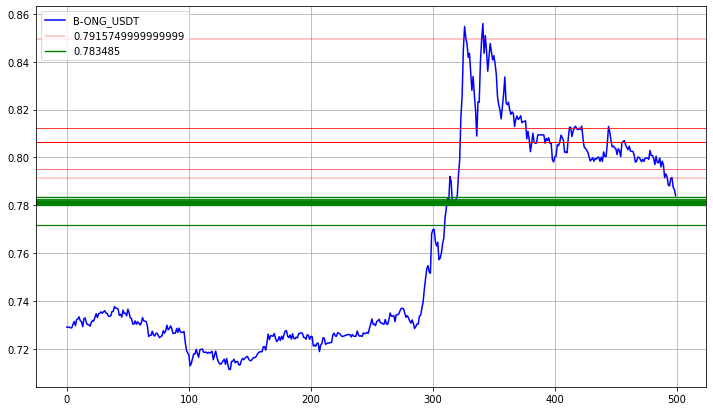

0.7963318575430056


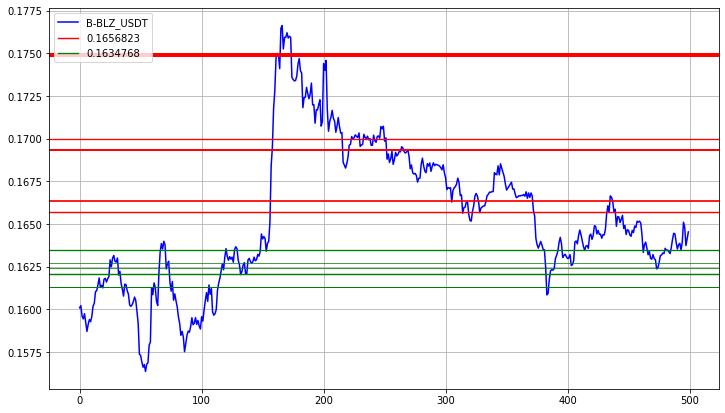

0.74575215172869


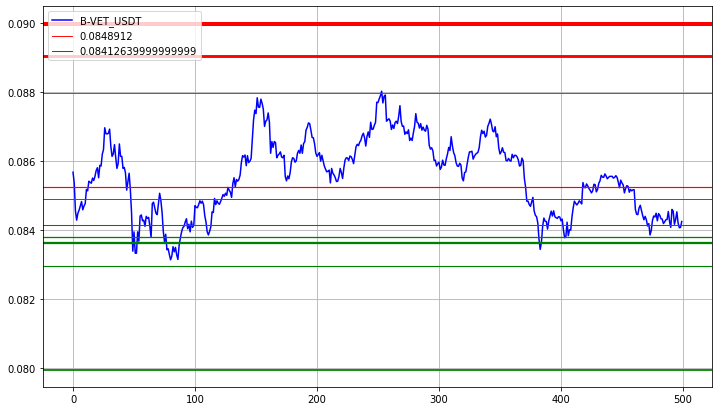

In [3]:
def plotCompare(pair,support,resistance):
  ohlc = getOHLC(pair)
  close = list(map(lambda x:x['close'],ohlc))
  close.reverse()

  maxRes = resistance[0][0]
  maxSup = support[0][0]
  minPriceRes = min(resistance)[0]
  minPriceSup = max(support)[0]
  maxQty = max(resistance[0][1],support[0][1])
  # plt.subplot(2, 1, 1)
  plt.figure(figsize=(12,7))
  plt.plot(close, color='blue', label= pair)
  for x in resistance:
    plt.axhline(y = x[0], color = 'r', linestyle = '-',linewidth=(x[1]/maxQty)*4,label=minPriceRes==x[0] and x[0] or None)
  for x in support:
    plt.axhline(y = x[0], color = 'g', linestyle = '-',linewidth=(x[1]/maxQty)*4,label=minPriceSup==x[0] and x[0] or None)
  plt.grid(True)
  plt.legend(loc='upper left')
  plt.show()

def comparePlot(lineNumber = 5,limitPercent = 0.05):
  topPlotNum = 3

  print("Pair" + "\t\t\t" + "SwingPower" + "\t\t" + "ProfitPercent")

  marketCoinPairs = ['B-MATIC_USDT','B-ADA_USDT','B-ONG_USDT','B-OGN_USDT','B-KSM_USDT','B-XRP_USDT','B-NANO_USDT','B-SUPER_USDT','B-TKO_USDT',
                    'B-ETH_USDT','B-BNB_USDT','B-BTC_USDT','B-XLM_USDT','B-DOT_USDT','B-TRX_USDT','B-DOGE_USDT','B-ONE_USDT','B-TFUEL_USDT',
                    'B-THETA_USDT','B-ETC_USDT','B-SHIB_USDT','B-OM_USDT','B-OMG_USDT','B-ICP_USDT','B-SOL_USDT','B-COTI_USDT','B-SKL_USDT',
                    'B-BLZ_USDT','B-UNFI_USDT','B-CTSI_USDT','B-UNI_USDT','B-EOS_USDT','B-KNC_USDT','B-RAMP_USDT','B-YFI_USDT','B-YFII_USDT',
                    'B-VET_USDT','B-CELR_USDT','B-1INCH_USDT','B-GXC_USDT','B-FIL_USDT','B-GTO_USDT','B-DATA_USDT']

  res = []
  for pair in marketCoinPairs:
    # returnData = depthDataPred(x)
    bids,asks = getDepthData(pair)
    bids,asks = limitExtractDepth(bids,asks,limitPercent)

    if len(bids)==0 or len(asks)==0:
      print("data Incomplete "+pair)
      continue

    resistance,support = getSupportResistance(bids,asks,pair,lineNumber,limitPercent)

    maxRes = resistance[0][0]
    maxSup = support[0][0]
    # swingPower =( maxRes - bids[0][0]) /( maxRes - maxSup)
    swingScore,swingPower = getSwingScorePower(support,resistance,bids[0][0])

    profitPercent = maxRes/bids[0][0]

    print(pair  + "\t\t" + str(swingPower) + "\t\t" + str(swingScore) + "\t\t" + str(profitPercent))
    res.append([swingPower,swingScore,profitPercent,pair,support,resistance])
  
  res.sort(key = lambda x: x[0],reverse=True)
  for x in range(topPlotNum):

    print(res[x][0])
    plotCompare(res[x][3],res[x][4],res[x][5])

comparePlot(5,.1)


MaxRes : 0.43899600000000005
MaxSup : 0.4319022
SwingPower : 0.6209110505208209
SwingScore : 1035.5534652037645


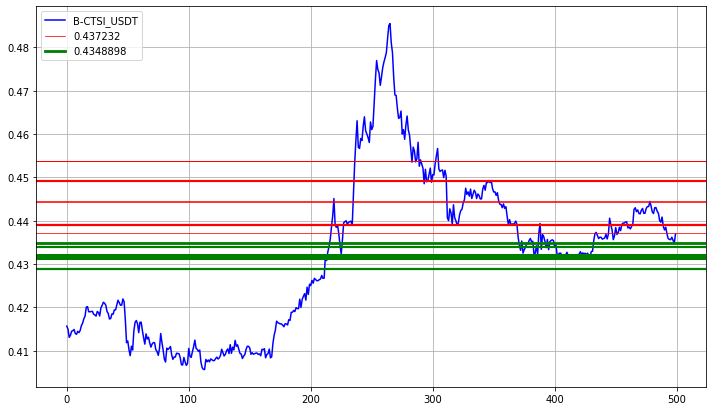

MaxRes : 1.1195368
MaxSup : 1.0725996
SwingPower : 0.9668788680994822
SwingScore : 8627.323267076952


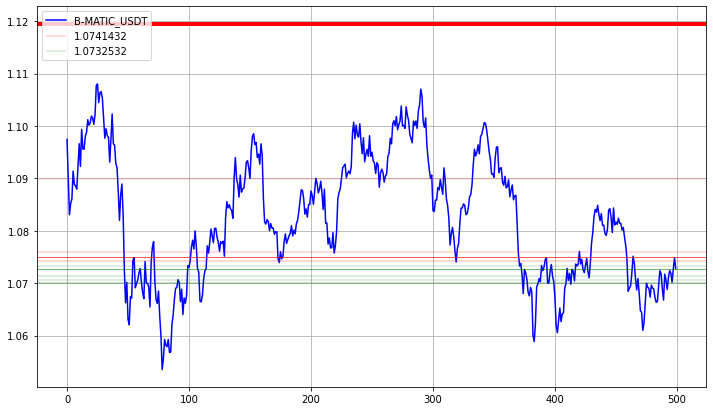

MaxRes : 19.63626
MaxSup : 19.004350000000002
SwingPower : 0.4360597570821017
SwingScore : -823.5462498721049


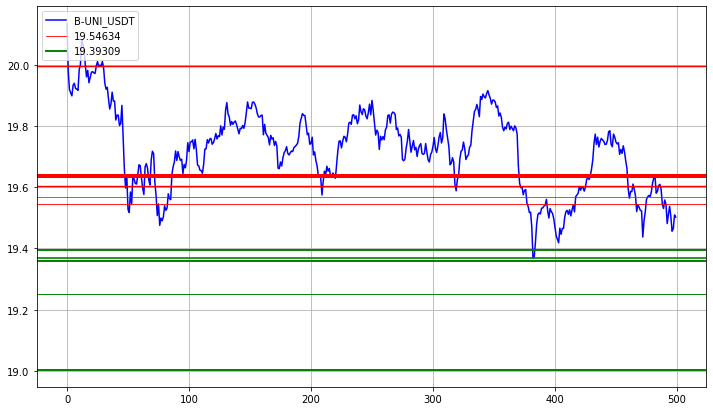

MaxRes : 2400.6319000000003
MaxSup : 2300.8949999999995
SwingPower : 0.5547411666897313
SwingScore : -101945.63081944105


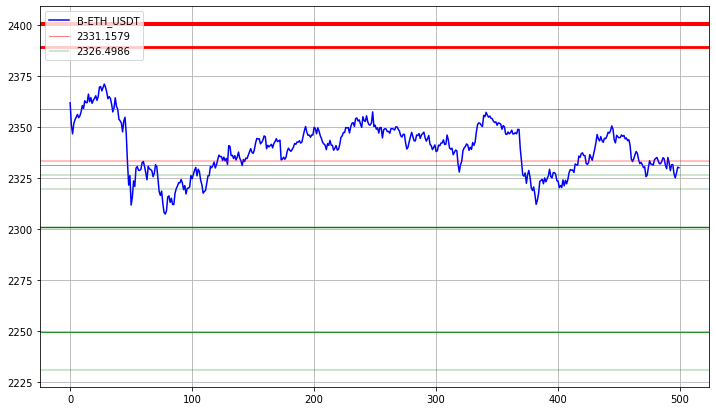

MaxRes : 1.327578
MaxSup : 1.299449
SwingPower : 0.22469448202948322
SwingScore : -3670.9515191911123


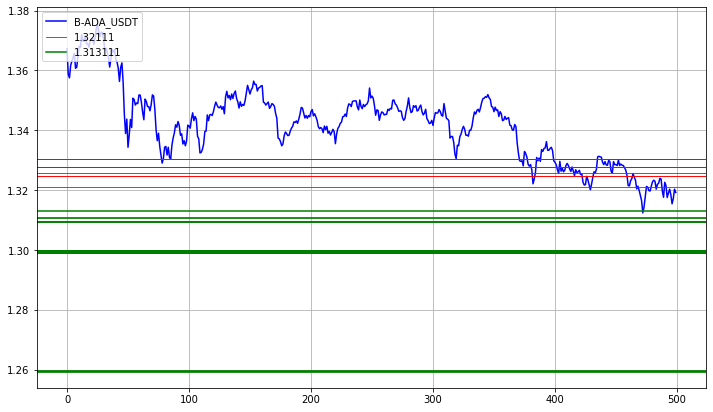

In [4]:
# main(pair ="B-GTO_USDT",lineNumber = 5,limitPercent = 0.05)
main(pair ="B-CTSI_USDT",lineNumber = 5,limitPercent = 0.05)
main(pair ="B-MATIC_USDT",lineNumber = 5,limitPercent = 0.05)
main(pair ="B-UNI_USDT",lineNumber = 5,limitPercent = 0.05)
main(pair ="B-ETH_USDT",lineNumber = 5,limitPercent = 0.05)
main(pair ="B-ADA_USDT",lineNumber = 5,limitPercent = 0.05)

In [5]:
# import time

# while True:
#   main(pair ="B-CHZ_USDT",lineNumber = 5,limitPercent = 0.05)
#   time.sleep(60)